In [1]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# import pydicom
# from pydicom import dcmread
from PIL import Image
import cv2
import tensorflow.keras.backend as K
# from fast_ml.model_development import train_valid_test_split

In [ ]:
Merged = pd.read_csv('/content/drive/MyDrive/Data/Merged.csv')

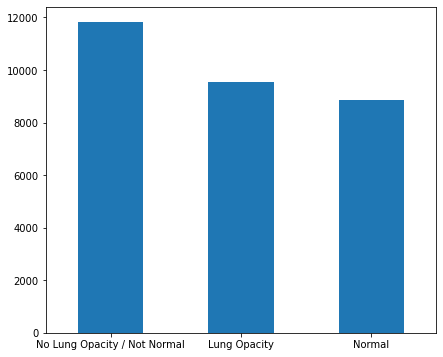

In [ ]:
Merged['class'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)

In [ ]:
Merged.head()

,index,patientId,class,x,y,width,height,Target,path,MASK
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
4,4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,/content/drive/MyDrive/Colab Notebooks/convert...,264.0 152.0 213.0 379.0


In [ ]:
def extract_coordinates(mergedindex):
  lst=[]
  lst=mergedindex.split(' ',4)
  lst = [int(float(j)) for j in lst]
  return lst

In [ ]:
def create_mask(list1):
  dim = np.zeros((1024,1024,))
  # dim.fill(0)
  # dim[list1[0]:list1[2],list1[1]:list1[3]]=1
  x,y,w,h = list1
  cv2.rectangle(dim,(x,y),(x+w,y+h),(255,0,0),-1)
  return dim

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, IMG_SIZE=None, n_channels=3,
                 n_classes=2,problem_type = 'segmentation', shuffle=True):
        'Initialization'
        self.IMG_SIZE = IMG_SIZE
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.dim = (IMG_SIZE,IMG_SIZE)
        self.on_epoch_end()
        self.mapping = {k:v for k,v in zip(self.list_IDs,self.labels) }
        self.problem_type=problem_type

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # print(indexes)
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes,), dtype=int)
        # y = np.zeros(len(list_IDs_temp),self.n_classes)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/converted_train_images/' + ID + '.dcm.jpg')
            # print(cv2.resize(img,(IMG_SIZE,IMG_SIZE)).shape)
            img = img.astype('float16')/img.max()
            # cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
            # img = img/img.max()
            X[i,] = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            label = np.zeros(2)
            if(self.mapping[ID]==0):
              label[0] = 1
            elif(self.mapping[ID]==1):
              label[1] = 1
            y[i,] = label
        return X,y
    def __repr__(self):
      print("Number of batches: ", str(len(self.list_IDs)/self.batch_size))

train_gen[batch no][X:0><Y:1][ith image in batch(range of i is 0 to 3]



In [ ]:
train = pd.read_csv('/content/drive/MyDrive/classification/train.csv')
valid = pd.read_csv('/content/drive/MyDrive/classification/valid.csv')
test = pd.read_csv('/content/drive/MyDrive/classification/test.csv')

In [ ]:
batch_size=4
IMG_SIZE=224
Train_gen = DataGenerator(list_IDs = list(train.patientId),
                          labels = list(train.Target),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=True)
print(len(Train_gen))

5289


In [ ]:
batch_size=4
IMG_SIZE=224
Val_gen = DataGenerator(list_IDs = list(valid.patientId),
                          labels = list(valid.Target),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=True)
print(len(Val_gen))

1133


In [ ]:
batch_size=1
IMG_SIZE=224
Test_gen = DataGenerator(list_IDs = list(test.patientId),
                          labels = list(test.Target),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=False)
print(len(Test_gen))

4534


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger,ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math

In [ ]:
def InceptionV3():
  # load the InceptionV3 network, ensuring the head FC layer sets are left off
  baseModel = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
)
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(output)
  output = tf.keras.layers.Flatten(name="flatten")(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.25)(output)
  output = tf.keras.layers.Dense(2, activation="softmax")(output)
  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

model = InceptionV3()
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 20
BATCHSIZE = 32
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss= 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_12 (Conv2D)             (None, 25, 25, 64)   16384       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 25, 25, 64)   76800       ['activation_13[0][0]']          
                                                                                                  
 conv2d_17 (Conv2D)             (None, 25, 25, 96)   82944       ['activation_16[0][0]']          
                                                                                                  
 conv2d_18 (Conv2D)             (None, 25, 25, 64)   16384       ['average_pooling2d_1[0][0]']    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 25, 25, 64)  192         ['conv2d_12[0][0]']              
 ormalizat

In [ ]:
modelPath = '/content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/InceptionV3_1-best-model.h5', monitor='val_loss',
                                                      verbose=1, save_best_only=True, mode='auto')

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True, verbose=1)

csv_path = '/content/drive/MyDrive/logs/Binary_Classification_InceptionV3_2.csv' 
csv_logger = CSVLogger(csv_path, append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7)

callbacks = [model_checkpoint, reduce_lr, early_stop,csv_logger]

STEP_TRAIN = len(Train_gen) // BATCHSIZE
STEP_TEST = len(Test_gen) // BATCHSIZE
modelHistory = model.fit(Train_gen, epochs=EPOCHS, verbose=1, callbacks=callbacks,
                         validation_data= Val_gen, shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)

tf.keras.models.save_model(model, '/content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/InceptionV3_1-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Created
Epoch 1/20
165/165 [==============================] - ETA: 0s - loss: 0.8788 - accuracy: 0.6591
Epoch 1: val_loss improved from inf to 0.58554, saving model to ./content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/InceptionV3_1-best-model.h5
165/165 [==============================] - 357s 2s/step - loss: 0.8788 - accuracy: 0.6591 - val_loss: 0.5855 - val_accuracy: 0.7057 - lr: 0.0010
Epoch 2/20
165/165 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.7227
Epoch 2: val_loss improved from 0.58554 to 0.48356, saving model to ./content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/InceptionV3_1-best-model.h5
165/165 [==============================] - 320s 2s/step - loss: 0.5731 - accuracy: 0.7227 - val_loss: 0.4836 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 3/20
165/165 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.7606
Epoch 3: val_loss improved from 0.48356 to 0.42183, savi

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/InceptionV3_1-model.h5')

In [ ]:
results = pd.DataFrame()
results['label'] = test.Target

In [ ]:
from tqdm.notebook import tqdm
pred_prob = []
for bno in tqdm(range(len(Test_gen))):
  pred = model.predict(Test_gen[bno][0])
  pred_prob.append(pred[0][1])

  0%|          | 0/4534 [00:00<?, ?it/s]

In [ ]:
results['pred_prob'] = pred_prob

In [2]:
results = pd.read_csv('/content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/predictions.csv')

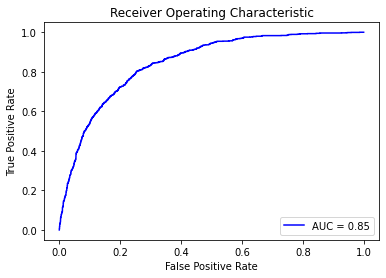

<Figure size 432x288 with 0 Axes>

In [3]:
import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(results.label, results.pred_prob)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('/content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3/AU|ROC-Curve.jpg')

In [4]:
from sklearn.metrics import classification_report,confusion_matrix
from tqdm.notebook import tqdm

In [5]:
inference = pd.DataFrame(columns = ['Threshold', 'Sensitivity','Specificity','Precision','Recall','F1-score'])
for i in tqdm(range(len(thresholds))):
  th = thresholds[i]
  results['pred_label']= results.pred_prob.apply(lambda x: 1 if x>th else 0)
  TN, FP, FN, TP = confusion_matrix(results.label,results.pred_label).ravel()
  Sensitivity = TP / (FN+TP)
  Specificity = TN/(FP+TN)
  Recall = TP / (FN+TP)
  Precision = TP/(TP+FP)
  f1_score = 2 * (Precision * Recall)/ (Precision + Recall)
  if(Sensitivity>=0.8):
    inference = inference.append({'Threshold':th,
                                  'Sensitivity':Sensitivity,
                                  'Specificity': Specificity,
                                  'Precision': Precision, 
                                  'Recall': Recall, 
                                  'F1-score':f1_score}, ignore_index=True)

  0%|          | 0/1170 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [6]:
inference.head()

,Threshold,Sensitivity,Specificity,Precision,Recall,F1-score
0,0.146030,0.800000,0.746609,0.556634,0.800000,0.656489
1,0.145386,0.800000,0.746301,0.556334,0.800000,0.656280
2,0.143390,0.801550,0.745068,0.555615,0.801550,0.656300
3,0.143262,0.801550,0.744760,0.555317,0.801550,0.656091
4,0.142684,0.802326,0.744143,0.554960,0.802326,0.656101


In [7]:
inference.to_csv('/content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/inference.csv')

In [ ]:
model_tracker = pd.read_csv('/content/drive/MyDrive/Model_Tracker_Deeptek.csv')

In [ ]:
model_tracker = pd.read_csv('/content/drive/MyDrive/Model_Tracker_Deeptek.csv')

model_tracker.append({'model_id': "IV3_2",
                      'architecture': "InceptionV3",
                      'batch_size': batch_size,
                      'img_size': IMG_SIZE,
                      'learning_rate': INIT_LR,
                      'optimizer': "Adam",
                      'lossfunction': "Binary Crossentropy",
                      'weight_path': "/content/drive/MyDrive/classification/saved Models/Pretrained InceptionV3_1/InceptionV3_1-model.h5" ,
                      'logs_path': "/content/drive/MyDrive/logs/Binary_Classification_InceptionV3_2.csv",
                      'Colab_URL': "https://colab.research.google.com/drive/1ZDqxDcG3IAaftRLxIEMKBSjCXxNzy4Nl#scrollTo=yWrAA3OrGBcP",
                      'comments': "The image size for this model training was changed to 224 x 224 instead of 512 x 512"},ignore_index = True)

,model_id,architecture,batch_size,img_size,learning_rate,optimizer,loss function,weight_path,logs_path,Colab_URL,comments,lossfunction
0,IV3_2,InceptionV3,1,224,0.001,Adam,NaN,/content/drive/MyDrive/classification/saved Mo...,/content/drive/MyDrive/logs/Binary_Classificat...,https://colab.research.google.com/drive/1ZDqxD...,The image size for this model training was cha...,Binary Crossentropy
